# Thêm thư viện và đọc dataset

In [1]:
#pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from numpy import log

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose



from pylab import rcParams
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Đọc dữ liệu, đồng thời gán kiểu Datetime cho cột <DTYYYYMMDD)
csv='VNM.csv'
df=pd.read_csv(csv, parse_dates=['<DTYYYYMMDD>'])

In [4]:
df.head(5)

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,VNM,2021-06-25,88.7,89.9,88.7,89.7,2079300
1,VNM,2021-06-24,89.9,90.2,88.3,88.7,4225000
2,VNM,2021-06-23,90.6,90.8,89.7,90.0,3357300
3,VNM,2021-06-22,91.0,91.5,90.6,90.6,2242800
4,VNM,2021-06-21,90.6,92.1,90.6,90.6,4193600


In [5]:
df.tail(5)

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
3837,VNM,2006-01-25,2.7280,2.7804,2.7280,2.7804,57220
3838,VNM,2006-01-24,2.7542,2.7542,2.7280,2.7280,66000
3839,VNM,2006-01-23,2.8329,2.8329,2.7542,2.7542,81400
3840,VNM,2006-01-20,2.7804,2.8854,2.8329,2.8329,157840
3841,VNM,2006-01-19,2.7804,2.7804,2.7804,2.7804,109350


# I. Mô tả dữ liệu

In [6]:
# Tạo hàm kiểm tra tổng quát mô tả dữ liệu
def data_overview(df):
    print(" SHAPE OF DATASET ".center(125,'-')) # Tạo tiêu đề SHAPE OF DATASET và canh giữa
    print('Rows:{}'.format(df.shape[0])) # Tạo dòng Rows, lấy tham số thứ [0] của hàm shape (số dòng)
    print('Columns:{}'.format(df.shape[1])) # Tạo dòng Rows, lấy tham số thứ [1] của hàm shape (số cột)
    
    print(" MISSING VALUES ".center(125,'-')) #Tạo tiêu đề MISSING VALUES và canh giữa
    # Đếm số các missing value của từng cột, sau đó lựa chọn các cột có missing value >0 và in ra theo thứu tự từ lớn đến bé
    print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False)) 
    
    print(" DUPLICATED VALUES ".center(125,'-')) #Tạo tiêu đề DUPLICATED VALUES và canh giữa
    print(df.duplicated().sum()) # In ra số các dòng trùng
    
    print(" STATISTICS OF DATA ".center(125,'-')) #Tạo tiêu đề STATISTICS OF DATA và canh giữa
    print(df.describe(include="all")) #In ra các chỉ số thống kê mô tả của dữ liệu
    
    print("DATA INFO".center(125,'-')) #Tạo tiêu đề DATA INFO và canh giữa
    print(df.info()) #In ra thông tin về các cột và kiểu dữ liệu của các cột
    
data_overview(df)

------------------------------------------------------ SHAPE OF DATASET -----------------------------------------------------
Rows:3842
Columns:7
------------------------------------------------------- MISSING VALUES ------------------------------------------------------
Series([], dtype: int64)
----------------------------------------------------- DUPLICATED VALUES -----------------------------------------------------
0
----------------------------------------------------- STATISTICS OF DATA ----------------------------------------------------
       <Ticker>                   <DTYYYYMMDD>       <Open>       <High>  \
count      3842                           3842  3842.000000  3842.000000   
unique        1                            NaN          NaN          NaN   
top         VNM                            NaN          NaN          NaN   
freq       3842                            NaN          NaN          NaN   
mean        NaN  2013-10-11 20:21:51.816762112    46.283232    46.759

--> Dữ liệu không có duplicate value và missing value

# II. Tiền xử lý

#### Đổi tên cột

In [7]:
columns_mapping = {'<Ticker>': 'Ticket',
                 '<DTYYYYMMDD>': 'Date',
                  '<Open>': 'Open',
                  '<High>': 'High',
                  '<Low>': 'Low',
                  '<Close>': 'Close',
                  '<Volume>': 'Volume'} # Tạo một dictionary lưu các cặp tên cột cũ và mới

df = df.rename(columns=columns_mapping) # Đổi tên các cột thành format thông thường dựa vào dictionary đã tạo trước đó
df.head(5)

,Ticket,Date,Open,High,Low,Close,Volume
0,VNM,2021-06-25,88.7,89.9,88.7,89.7,2079300
1,VNM,2021-06-24,89.9,90.2,88.3,88.7,4225000
2,VNM,2021-06-23,90.6,90.8,89.7,90.0,3357300
3,VNM,2021-06-22,91.0,91.5,90.6,90.6,2242800
4,VNM,2021-06-21,90.6,92.1,90.6,90.6,4193600


#### Sort value cột 'Date' theo ASC

In [8]:
df = df.sort_values(by='Date') # Sắp xếp lại các hàng theo thứ tự thời gain từ xa nhất đến gần nhất theo cột 'Date'
df = df.reset_index(drop=True) # Reset index, # drop=True để không thêm index vào thành column mới 

#### Kiểm tra ngày bắt đầu và kết thúc của time series

In [9]:
df.head(3) # Xem 3 hàng đầu

,Ticket,Date,Open,High,Low,Close,Volume
0,VNM,2006-01-19,2.7804,2.7804,2.7804,2.7804,109350
1,VNM,2006-01-20,2.7804,2.8854,2.8329,2.8329,157840
2,VNM,2006-01-23,2.8329,2.8329,2.7542,2.7542,81400


---> start_date = '2006-01-19'

In [10]:
df.tail(3) # Xem 3 hàng cuối

,Ticket,Date,Open,High,Low,Close,Volume
3839,VNM,2021-06-23,90.6,90.8,89.7,90.0,3357300
3840,VNM,2021-06-24,89.9,90.2,88.3,88.7,4225000
3841,VNM,2021-06-25,88.7,89.9,88.7,89.7,2079300


---> end_date = '2021-06-25'

## Xử lý outlier

#### Histogram

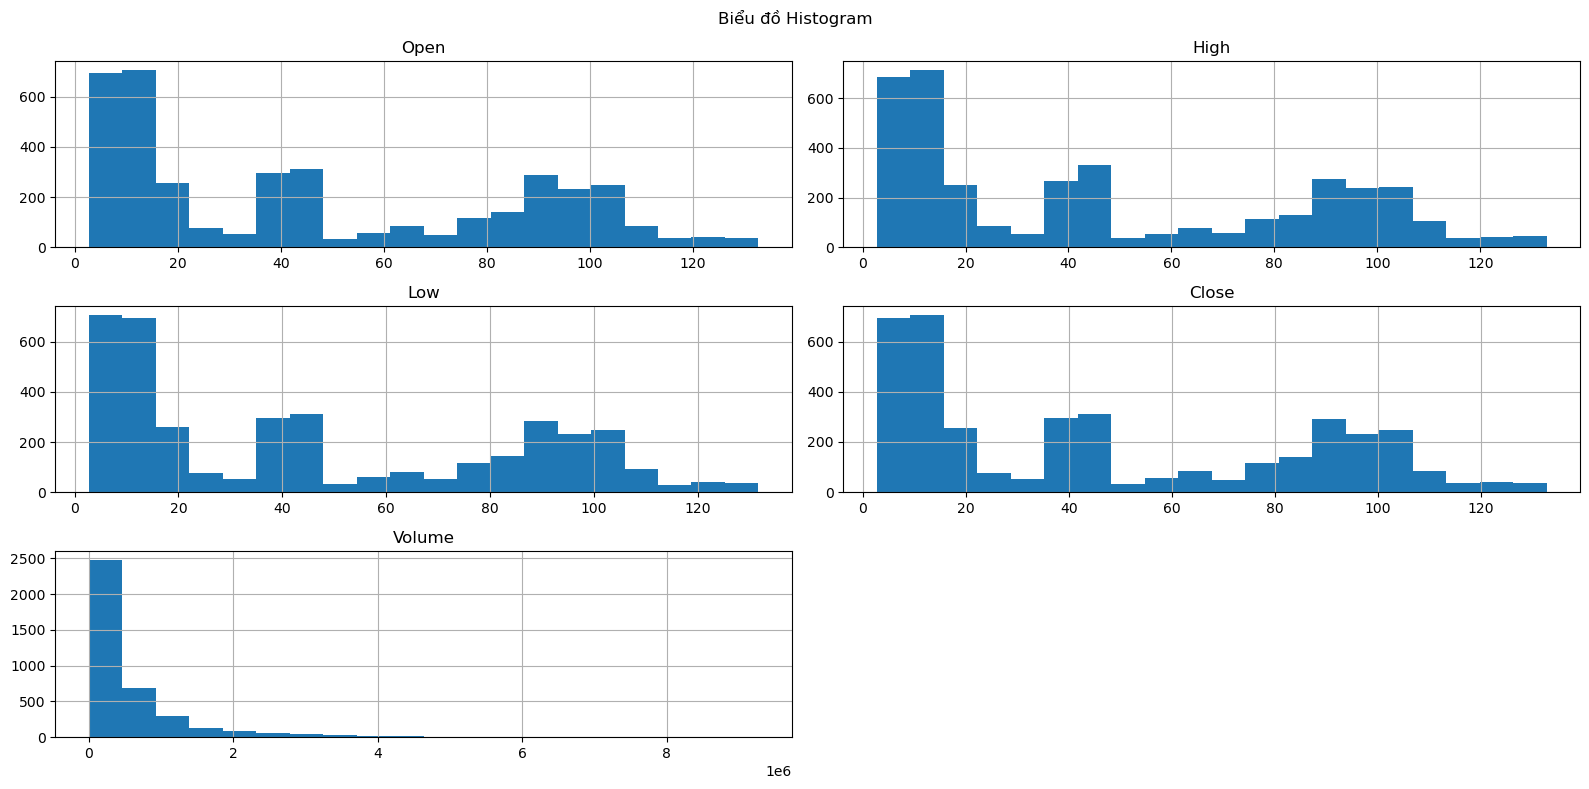

In [11]:
biendinhluong = ['Open', 'High', 'Low', 'Close', 'Volume'] # Tạo 1 list gồm danh sách các biến định lượng
df[biendinhluong].hist(bins=20, figsize=(16, 8), layout=(3, 2)) # Vẽ histogram cho từng biến định lượng với số lượng bin = 20, kích thước (16,8), layout 3 hàng 2 cột 
plt.suptitle("Biểu đồ Histogram")  # In ra title biểu đồ 
plt.tight_layout() # Tự động tinh chỉnh khoảng cách giữa các plot cho phù hợp
plt.show()

---> Nhìn chung, các biến định lượng có phân phối không đều, chủ yếu rất lệch phải

#### Box plot

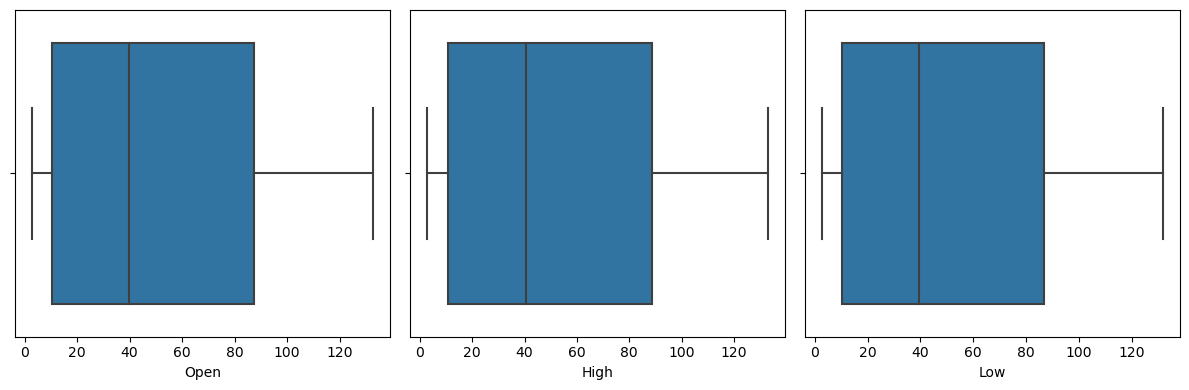

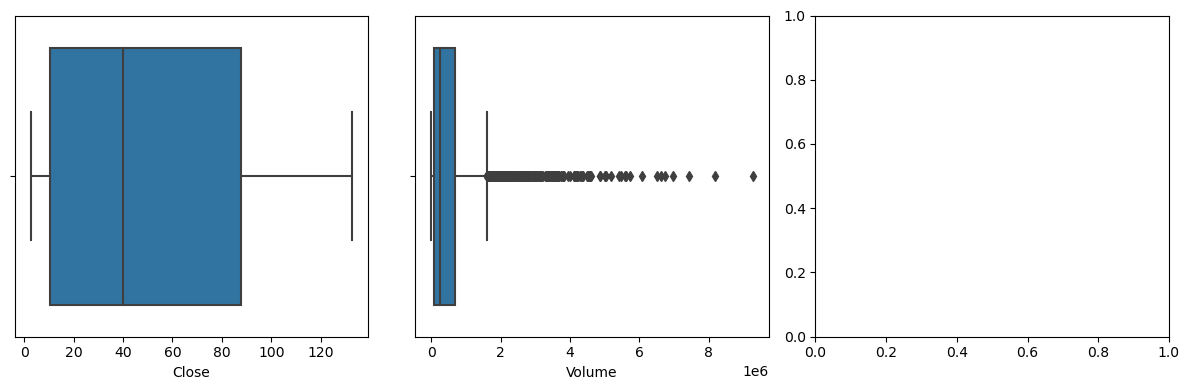

In [12]:
# Tạo vòng lặp in ra boxplot của từng biến định lượng theo từng dòng (3 box plot mỗi dòng)
for i in range(0, len(biendinhluong), 3): # Vòng lặp for với i trong khoảng từ 0 đến (chiều dài của list - 1), bước nhảy=3
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))  # Tùy chỉnh mỗi dòng biểu đồ gồm 3 cột ứng với 3 biểu đồ
                                                                 # Kích thước figure = 12x4

    #Trong mỗi vòng for in ra theo dòng, tạo vòng lặp for mới in ra 3 boxplot
    for col_idx, col in enumerate(biendinhluong[i:i+3]): #Truy xuất từng cặp index và phần tử bằng hàm liệt kê enumerate
        ax = axes[col_idx]  # Chỉ định biểu đồ in ra tại vị trí xác định
        sns.boxplot(x=col, data=df, ax=ax)  # Plot boxplot

    plt.tight_layout()  # Tự động tinh chỉnh khoảng cách giữa các plot cho phù hợp

    plt.show() # Show plot

---> Từ boxplot, nhận thấy dữ liệu có khá ít outliers, tập trung chủ yếu tại cột 'Volume'

#### Đếm và loại bỏ outlier

In [13]:
for i in biendinhluong: #Tạo vòng lặp đếm outlier cho từng biến định lượng
  Q1 = df[i].quantile(0.25) # Tứ phân vị thứ 1
  Q3= df[i].quantile(0.75) # tứ phân vị thứ 3
  IQR = Q3-Q1 # Khoảng giữa tứ phân vị thứ 1 và tứ phân vị thứ 3
  lower = Q1-3*IQR # tính lower cho các extreme outliers 
  upper = Q3+3*IQR # tính upper cho các extreme outliers
  outliers_dem = ((df[i]<lower) | (df[i]>upper)).sum() # Đếm số outliers = các dữ liệu nằm ngoài 2 đầu của box plot
  outliers_tile = np.round(outliers_dem/len(df),decimals=2) # Tính %outliers so với tổng số, làm tròn 2 chữ số phần thập phân
  print(i,"chứa",outliers_dem,"giá trị ngoại lai, chiếm tỉ lệ",outliers_tile,"%")

Open chứa 0 giá trị ngoại lai, chiếm tỉ lệ 0.0 %
High chứa 0 giá trị ngoại lai, chiếm tỉ lệ 0.0 %
Low chứa 0 giá trị ngoại lai, chiếm tỉ lệ 0.0 %
Close chứa 0 giá trị ngoại lai, chiếm tỉ lệ 0.0 %
Volume chứa 150 giá trị ngoại lai, chiếm tỉ lệ 0.04 %


In [14]:
for i in biendinhluong: # Tạo vòng lặp để xóa các outliers
  Q1 = df[i].quantile(0.25) # Tứ phân vị thứ 1
  Q3=df[i].quantile(0.75) # Tứ phân vị thứ 3
  IQR = Q3-Q1 # Khoảng giữa tứ phân vị thứ 1 và tứ phân vị thứ 3
  lower = Q1-3*IQR # Tính lower cho các extreme outliers
  upper = Q3+3*IQR # Tính upper cho các extreme outliers
  df = df[(df[i]>=lower) & (df[i]<=upper)|(df[i].isnull())] 
df.reset_index(drop=True, inplace=True) 
# Reset thứ tự các record thành số tự nhiên liên tiếp
# drop=True để không thêm index vào thành column mới 
# inplace=True để xóa trực tiếp trong dữ liệu gốc

#### Histogram của Volumn sau khi loại bỏ outlier

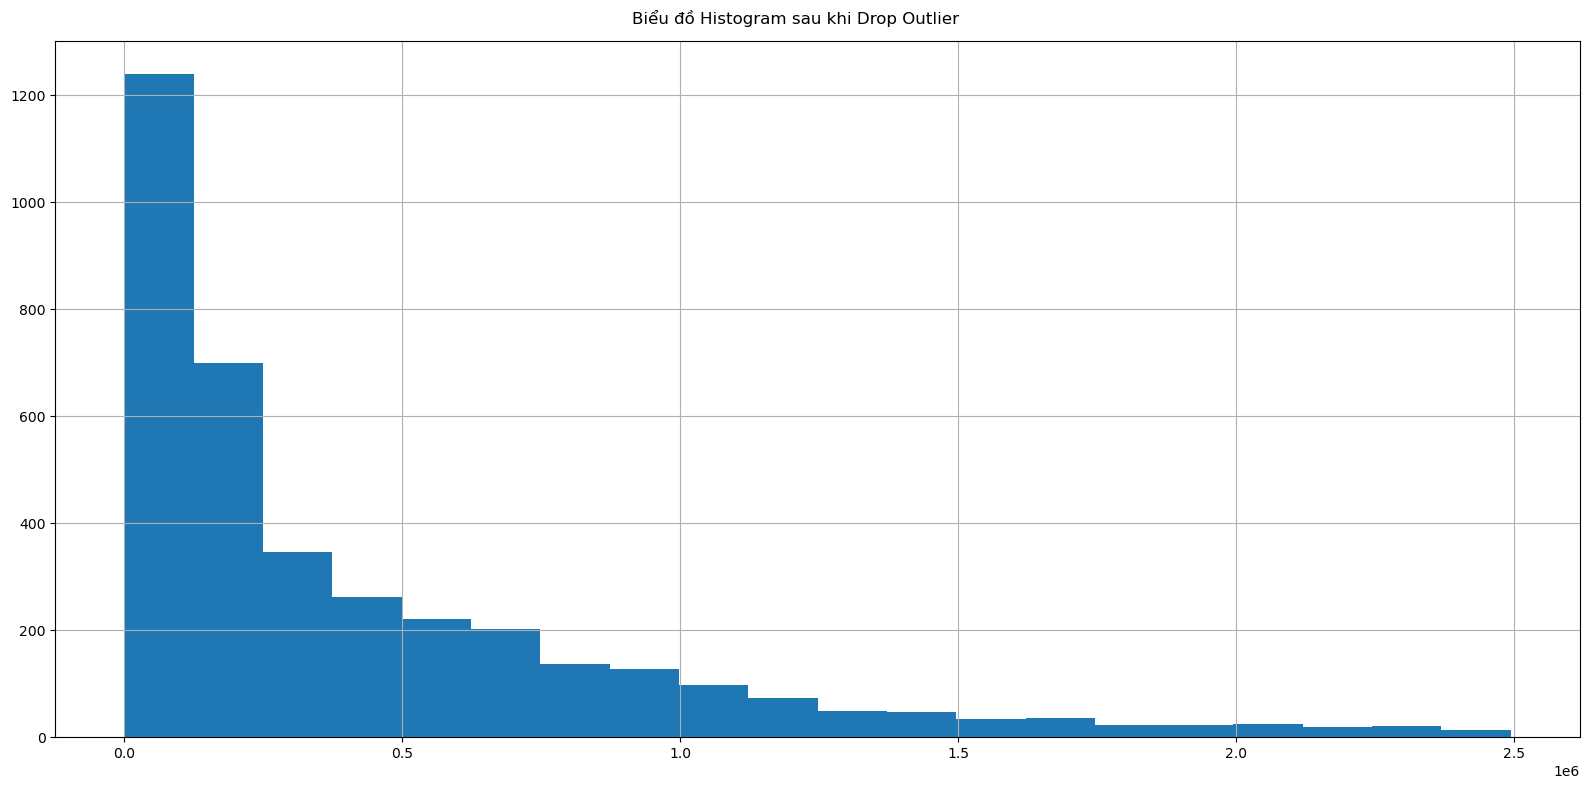

In [15]:
df['Volume'].hist(bins=20, figsize=(16, 8)) # Vẽ histogram cho từng biến định lượng với số lượng bin = 20, kích thước (16,8), layout 3 hàng 2 cột 
plt.suptitle("Biểu đồ Histogram sau khi Drop Outlier")  # In ra title biểu đồ 
plt.tight_layout() # Tự động tinh chỉnh khoảng cách giữa các plot cho phù hợp
plt.show()

#### Boxplot của 'Volume' sau khi loại bỏ outlier

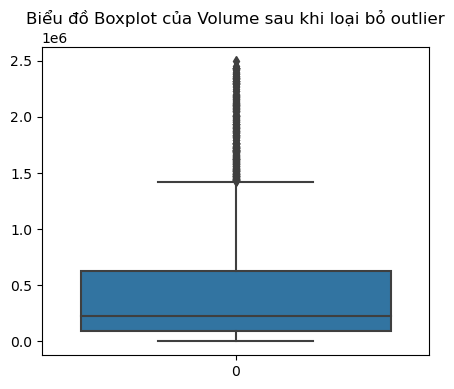

In [16]:
fig, ax = plt.subplots(figsize=(5,4))
sns.boxplot(data=df["Volume"])
plt.title("Biểu đồ Boxplot của Volume sau khi loại bỏ outlier")
plt.show()

#### Tương quan các biến định lượng sau khi xóa outlier

Text(0.5, 1.0, 'Correlation Heatmap')

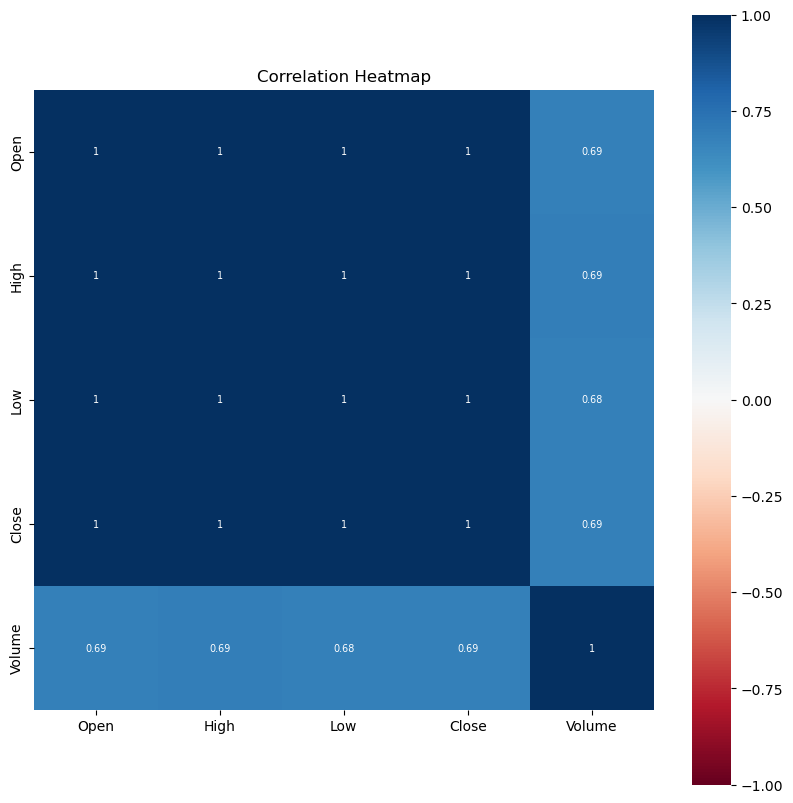

In [38]:
# Vẽ heatmap các correlation
fig, ax = plt.subplots(figsize=(10,10)) # Chỉnh figsize

# Plot hệ số tương quan của các biến định lượng, tinh chỉnh cho heatmap dạng vuông và thang đo màu RdBu, 
# Hiện giá trị tương quan từng ô, chạy từ -1 đến 1 và giá trị tương quan có cỡ chữ small, 
sns.heatmap(df[biendinhluong].corr(),cmap='RdBu',square=True,annot=True,annot_kws={'size': 'x-small'},vmin=-1, vmax=1) 
plt.title('Correlation Heatmap')

---> Nhìn chung, các biến khác đều thể hiện tương quan thuận rất mạnh đối với biến "Close"

# III.Time series prediction

## 1. Mô tả tính chất Time series

In [18]:
# Set cột Date thành index
ts=df[['Close','Date']]
ts = ts.set_index('Date')
ts

,Close
Date,
2006-01-19,2.7804
2006-01-20,2.8329
2006-01-23,2.7542
2006-01-24,2.7280
2006-01-25,2.7804
...,...
2021-03-19,100.4504
2021-06-01,88.7954
2021-06-17,91.0000


#### Xem xét tính xu hướng (trend), mùa vụ (seasonal), noise (outlier không giải thích dc bằng trend hay seasonal)

<Axes: xlabel='Date'>

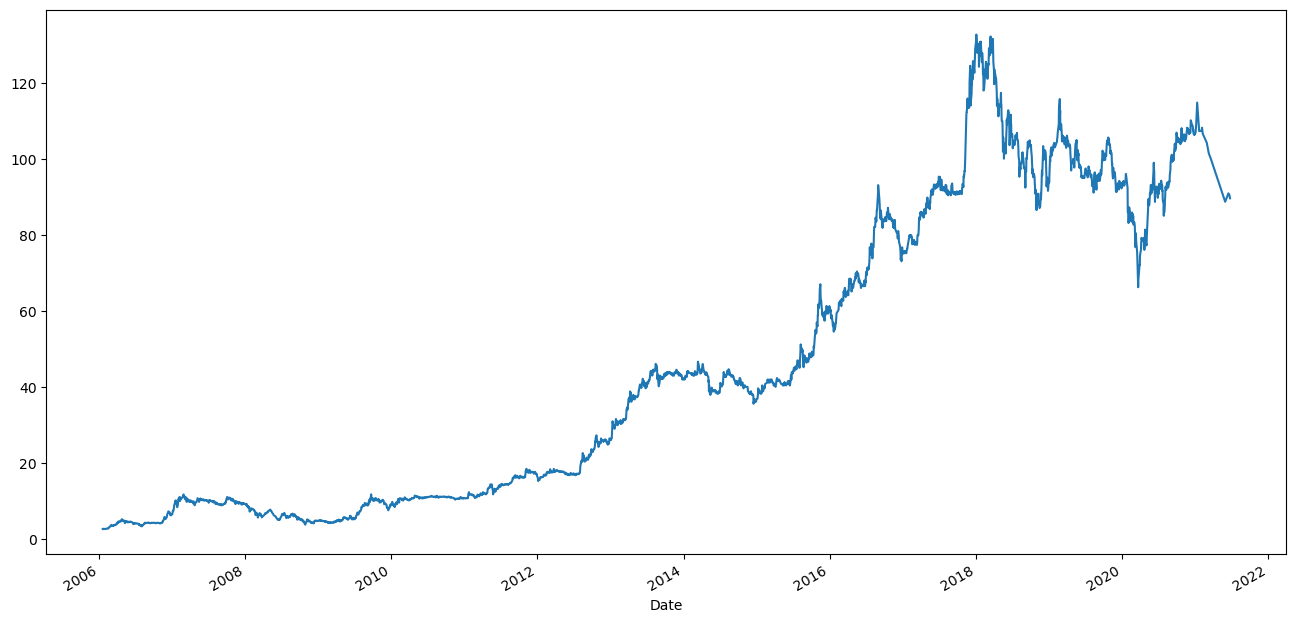

In [19]:
# Plot cột "Close"
ts['Close'].plot(figsize=(16,8)) #Kích thước biểu đồ 16x8

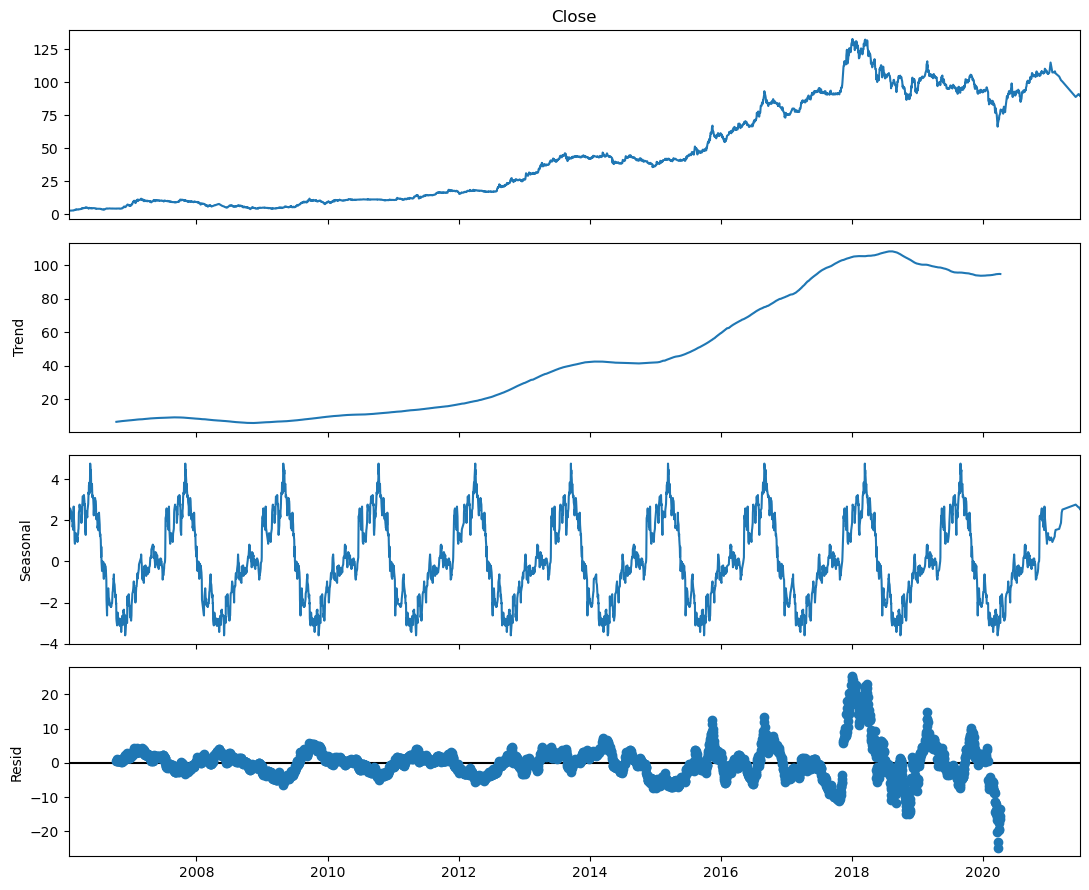

In [20]:
# Sử dụng seasonal_decompose để phân time series thành các component nhằm xem xu hướng, chu kỳ và các ngoại lệ (residuals)
rcParams['figure.figsize'] = 11, 9 #Kích thước biểu đồ 11*9
decomposed = sm.tsa.seasonal_decompose(ts["Close"],period=365) # Chọn chu kỳ = 5
figure = decomposed.plot()
plt.show()

---> Dữ liệu có tính xu hương tăng dần, tính chu kỳ không rõ ràng và có thể trải dài hơn 1 năm (mùa vụ)

## 2.Triển khai mô hình

#### Chia dataset thành 2 tập train/test

In [21]:
# Dataset trải dài trong khoảng 15 năm, lựa chọn 2 năm cuối để test
split_point = pd.to_datetime('2019-06-25') #Chọn điểm phân chia là "2019-06-25"
train = ts[ts.index < split_point] # Tập train gồm các dòng dữ liệu trước mốc "2019-06-25"
test = ts[ts.index >= split_point] # Tập test gồm các dong dữ liệu sau mốc "2019-06-25"
print('Kích thước tập train',len(train)) #I n ra kích thước tập train
print('Kích thước tập test',len(test)) # In ra kích thước tập test

Kích thước tập train 3317
Kích thước tập test 375


#### Kiểm tra tính dừng của tập train bằng Augmented Dickey–Fuller test (ADF) test với mức ý nghĩa 0,05

In [22]:
result = adfuller(train) # Áp dụng ADF test với tập train

# In ra lần lượt các output của ADF test với tiêu đề tương ứng
print("ADF Statistic:", result[0]) 
print("p-value:", result[1])
print("Số Lag:", result[2])
print("Số quan sát", result[3])
print("Critical Values", result[4])

ADF Statistic: -0.251993766846698
p-value: 0.932033624658803
Số Lag: 29
Số quan sát 3287
Critical Values {'1%': -3.43234099912876, '5%': -2.862419705448909, '10%': -2.5672382855426354}


---> p-value>0,05 và trị tuyệt đối của ADF Statistic bé hơn nhiều so với trị tuyệt đối của giá trị tới hạn tại mức ý nghĩa 0,05 ---> Chưa đủ điều kiện để bác bỏ Ho ---> Chưa thể khẳng định dữ liệu có tính dừng

#### Kiểm tra tính dừng của tập train bằng ADF test với d=1

In [23]:
result = adfuller(train.diff().dropna()) # Áp dụng ADF test với tập train với d=1

# In ra lần lượt các output của ADF test với tiêu đề tương ứng
print("ADF Statistic:", result[0]) 
print("p-value:", result[1])
print("Số Lag:", result[2])
print("Số quan sát", result[3])
print("Critical Values", result[4])
print("Critical Values", result[4])

ADF Statistic: -9.807864339904336
p-value: 5.761424088077275e-17
Số Lag: 28
Số quan sát 3287
Critical Values {'1%': -3.43234099912876, '5%': -2.862419705448909, '10%': -2.5672382855426354}
Critical Values {'1%': -3.43234099912876, '5%': -2.862419705448909, '10%': -2.5672382855426354}


---> p-value<0,05 và trị tuyệt đối của ADF Statistic lớn hơn so với trị tuyệt đối của giá trị tới hạn tại mức ý nghĩa 0,05 ---> Bác bỏ Ho 
---> Dữ liệu có tính dừng

---> Lựa chọn d=1

<Axes: xlabel='Date'>

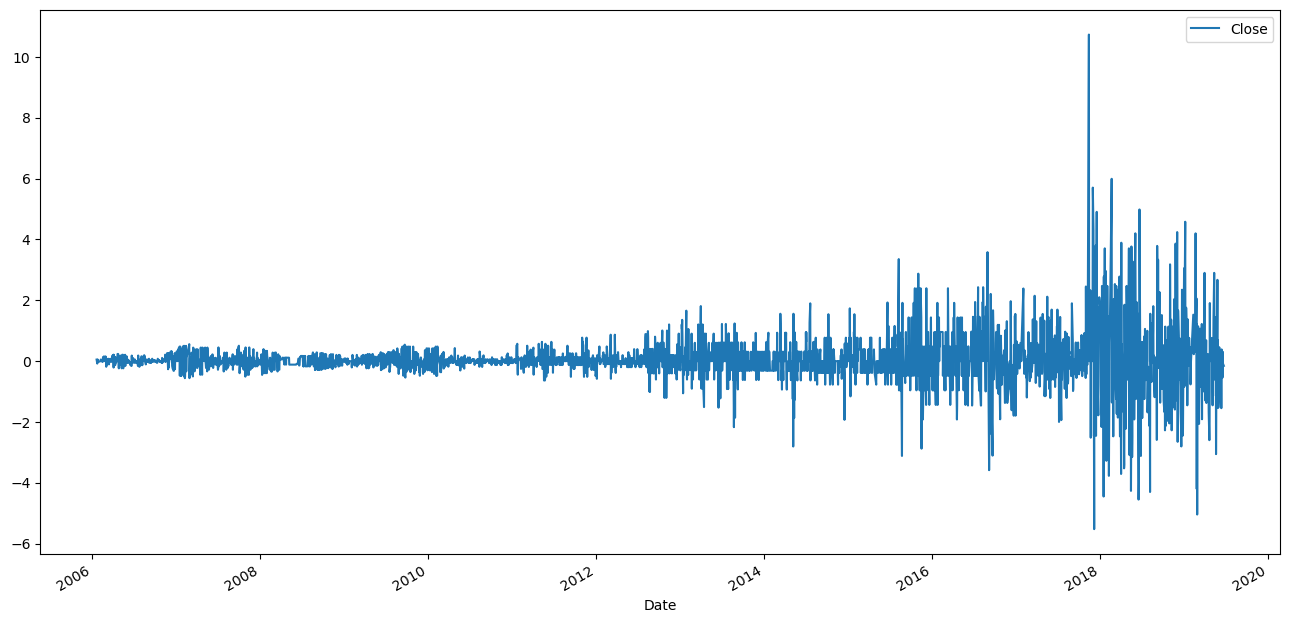

In [24]:
train.diff().plot(figsize=(16,8)) #Plot tập train sau khi differencing với d=1

#### Vẽ biểu đồ ACF và PACF đối với tập train sau khi differencing với d=1

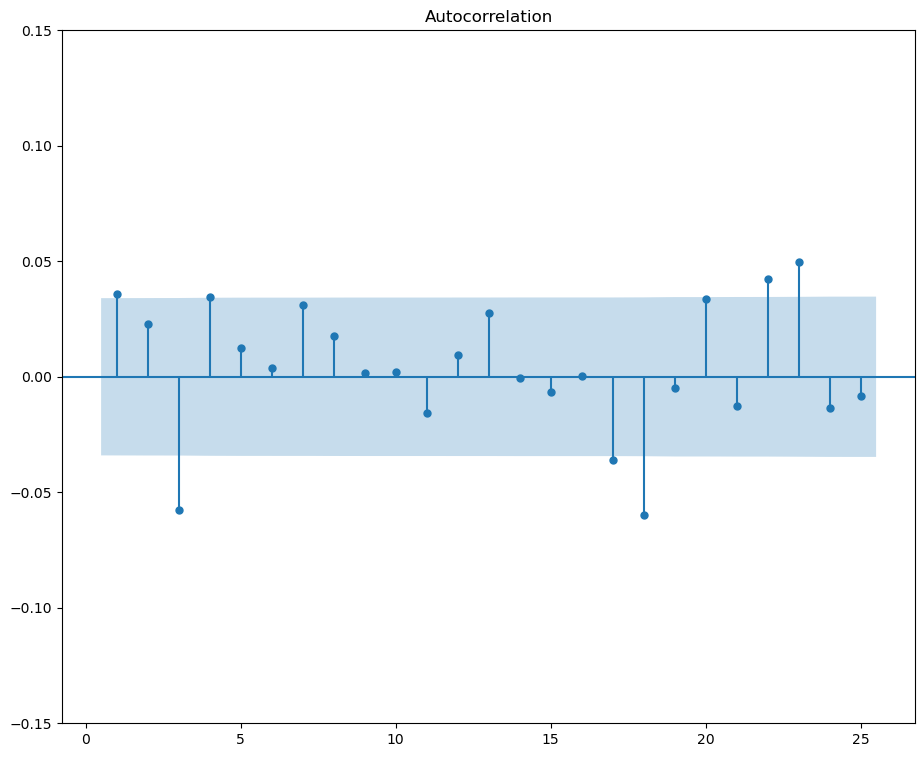

In [25]:
plot_acf(train.diff().dropna(),lags=25, alpha=0.05,zero=False) # Vẽ biểu đồ acf với lag=25 và alpha=0,05, zero=False để không hiện giá trị với lag=0
plt.gca().set_ylim(-0.15, 0.15) # Đặt max limit của trục y thành -0.15 đến 015 để làm tăng tính dễ quan sát
plt.show()

---> Số lag nhỏ nhất mà Giá trị tương quan ACF nằm xa ra ngoài khoảng tin cậy 95% là 3, do đó lựa chọn q=[0,1,2,3]

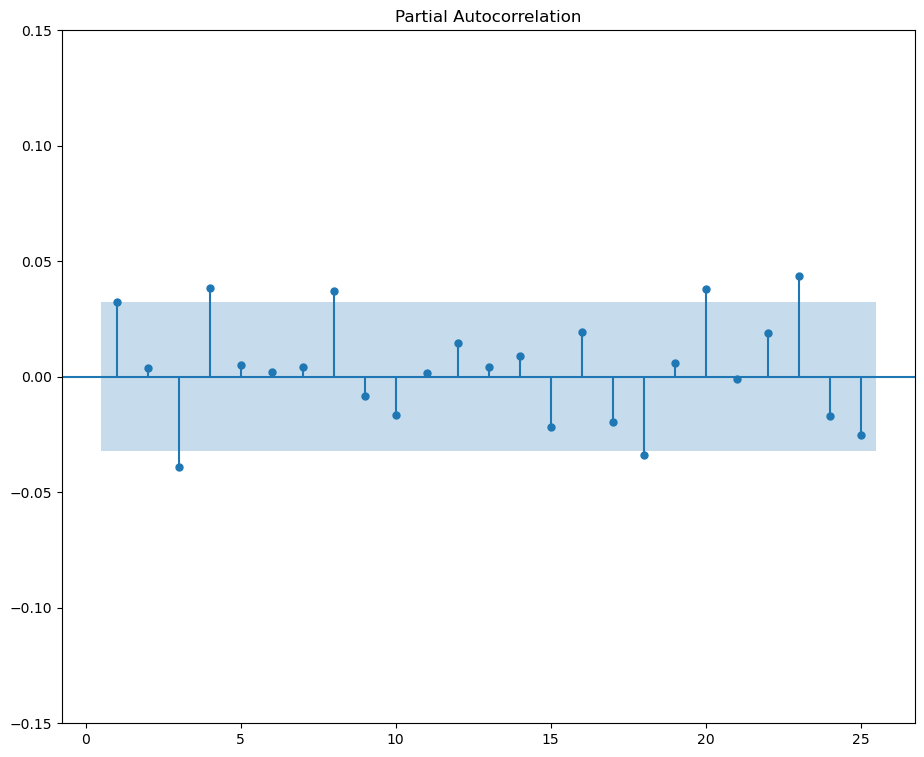

In [26]:
plot_pacf(ts['Close'].diff().dropna(), lags=25, alpha=0.05, zero=False) # Vẽ biểu đồ pacf với lag=25 và alpha=0,05, zero=False để không hiện giá trị với lag=0
plt.gca().set_ylim(-0.15, 0.15) # Đặt max limit của trục y thành -0.15 đến 015 để làm tăng tính dễ quan sát
plt.show()

---> Số lag nhỏ nhất mà Giá trị tương quan PACF nằm xa ra ngoài khoảng tin cậy 95% là 3, do đó lựa chọn p=[0,1,2,3]

#### Lựa chọn mô hình phù hợp

In [40]:
# Lựa chọn mô hình phù hợp bằng phương pháp stepwise với auto_arima
model = auto_arima(train, start_p=1, start_q=1, # Chọn p và q khởi đầu là 1
                           max_p=3, max_q=3, m=0, # Chọn p và q lớn nhất là 3
                           start_P=0, seasonal=False, #seasonal=True để không xét tính mùa vụ trong mô hình ARIMA
                           d=1, D=0, # Setting các tham số mùa vụ thành 0 và d là 1
                           trace=True, # In ra thông tin từng quá trình thực hiện
                           error_action='ignore',  # Bỏ qua lỗi nếu có
                           suppress_warnings=True, # Bỏ qua các warning nếu có
                           stepwise=True # Sử dụng chiến lược stepwise nhằm chọn mô hình tối ưu với chỉ số đánh giá là AIC
                           )

print('AIC của model tốt nhất:',model.aic()) # In ra AIC của mô hình tối ưu

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7861.418, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7862.122, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7859.816, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7860.016, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7864.228, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7860.251, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7854.316, Time=1.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7849.592, Time=1.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7850.518, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7842.530, Time=3.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7840.579, Time=2.86 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7852.932, Time=1.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7842.532, Time=4.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7848.353, Time=2.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

---> Từ kết quả của auto_arima, mô hình có AIC nhỏ nhất là ARIMA(2,1,2) với AIC=7840.579052505713 ---> Lựa chọn mô hình ARIMA(2,1,2)

## 3. Autoregresive Model

Autoregressive Model cần được sử dụng với chuỗi thời gian dừng, nhưng trong phạm vi project sử dụng AR model như một benchmark model để so sánh với ARIMA model. Vì vậy, áp dụng lại tham số đã tính tính từ model ARIMA (p=2) cho mô hình AR

In [28]:
ar_model = ARIMA(train, order=(2,0,0)) # Thực hiện model AR(2) với hàm thay thế tương ứng là ARIMA(2,0,0)
ar_model_fit = ar_model.fit() # Fit model sau thi thực hiện
print(ar_model_fit.summary()) # Xuất ra kết quả đánh giá tổng quan

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3317
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -3934.345
Date:                Fri, 19 Apr 2024   AIC                           7876.691
Time:                        21:44:25   BIC                           7901.118
Sample:                             0   HQIC                          7885.432
                               - 3317                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.5905    674.162      0.057      0.954   -1282.743    1359.924
ar.L1          1.0372      0.008    130.975      0.000       1.022       1.053
ar.L2         -0.0372      0.008     -4.705      0.0

---> Nhìn chung, tất cả các hệ số ước lượng của mô hình đều có ý nghĩa thống kê (p-value>0,05) ngoại trừ hệ số tự do (const).

In [29]:
ar_predictions = ar_model_fit.predict(start='2006-01-19', end='2019-06-24') #Thực hiện predict cho tập train
ts['ar_predicted'] = ar_predictions #Lưu kết quả predict thành 1 cột trong ts

ar_forecast = ar_model_fit.forecast(steps=len(test)) #Thực hiện forecast để so sánh với tập test
ar_forecast = pd.DataFrame(ar_forecast) # Chuyển forecast từ dạng Series thành DataFrame
ar_forecast.index=test.index # Đặt in dex cho DataFrame forecast thành index của tập test
ts['ar_forecast'] = ar_forecast #Lưu thành 1 cột trong ts

ts['ar_error'] = ts['Close']-ts['ar_predicted'].fillna(0)-ts['ar_forecast'].fillna(0) #Tính FE lưu thành cột mới trong ts

# 4. Moving-average Model

Moving-average Model cần được sử dụng với chuỗi thời gian dừng, nhưng trong phạm vi project sử dụng MA model như một benchmark model để so sánh với ARIMA model. Vì vậy, áp dụng lại tham số đã tính tính từ model ARIMA (q=2) cho mô hình MA

In [30]:
ma_model = ARIMA(train, order=(0,0,2)) # Thực hiện model MA(2) với hàm thay thế tương ứng là ARIMA(0,0,2)
ma_model_fit = ma_model.fit() # Fit model sau thi thực hiện
print(ma_model_fit.summary()) # Xuất ra kết quả đánh giá tổng quan

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3317
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -12345.077
Date:                Fri, 19 Apr 2024   AIC                          24698.153
Time:                        21:44:27   BIC                          24722.580
Sample:                             0   HQIC                         24706.895
                               - 3317                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.5962      0.939     41.125      0.000      36.757      40.436
ma.L1          1.7910      0.005    389.479      0.000       1.782       1.800
ma.L2          0.9270      0.005    203.831      0.0

---> Nhìn chung, tất cả các hệ số ước lượng của mô hình đều có ý nghĩa thống kê (p-value>0,05)

In [31]:
ma_predictions = ma_model_fit.predict(start='2006-01-19', end='2019-06-24') #Thực hiện predict cho tập train
ts['ma_predicted'] = ma_predictions #Lưu kết quả predict thành 1 cột trong ts

ma_forecast = ma_model_fit.forecast(steps=len(test)) #Thực hiện forecast để so sánh với tập test
ma_forecast = pd.DataFrame(ma_forecast) #Chuyển forecast từ dạng Series thành DataFrame
ma_forecast.index=test.index  # Đặt in dex cho DataFrame forecast thành index của tập test
ts['ma_forecast'] = ma_forecast #Lưu thành 1 cột trong ts

ts['ma_error'] = ts['Close']-ts['ma_predicted'].fillna(0)-ts['ma_forecast'].fillna(0) #Tính FE lưu thành cột mới trong ts

## 5. ARIMA

In [32]:
arima_model = ARIMA(train, order=(2,1,2)) # Thực hiện model ARIMA (2,1,2)
arima_model_fit = arima_model.fit() # Fit model sau thi thực hiện
print(arima_model_fit.summary()) # Xuất ra kết quả đánh giá tổng quan

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3317
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3916.240
Date:                Fri, 19 Apr 2024   AIC                           7842.481
Time:                        21:44:29   BIC                           7873.013
Sample:                             0   HQIC                          7853.407
                               - 3317                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9121      0.023    -39.465      0.000      -0.957      -0.867
ar.L2         -0.8524      0.023    -37.397      0.000      -0.897      -0.808
ma.L1          0.9493      0.020     46.903      0.0

---> Nhìn chung, tất cả các hệ số ước lượng của mô hình đều có ý nghĩa thống kê (p-value>0,05)

In [33]:
arima_predictions = arima_model_fit.predict(start='2006-01-19', end='2019-06-24') #Thực hiện predict cho tập train
ts['arima_predicted'] = arima_predictions #Lưu kết quả predict thành 1 cột trong ts

arima_forecast = arima_model_fit.forecast(steps=len(test)) #Thực hiện forecast để so sánh với tập test
arima_forecast = pd.DataFrame(arima_forecast) #Chuyển forecast từ dạng Series thành DataFrame
arima_forecast.index=test.index # Đặt in dex cho DataFrame forecast thành index của tập test
ts['arima_forecast'] = arima_forecast #Lưu thành 1 cột trong ts

ts['arima_error'] = (ts['Close']-ts['arima_predicted'].fillna(0))-ts['arima_forecast'].fillna(0) #Tính FE lưu thành cột mới trong ts

# 6. Plot kết quả dự đoán và dự báo

Với chuỗi thời gian trải dài 15 năm, khi plot kết quả dự đoán cần chia thành các khoảng thời gian nhỏ hơn nhằm tăng tính dễ quan sát

#### Plot kết quả mô hình AR trong các khoảng thời gian 5 năm

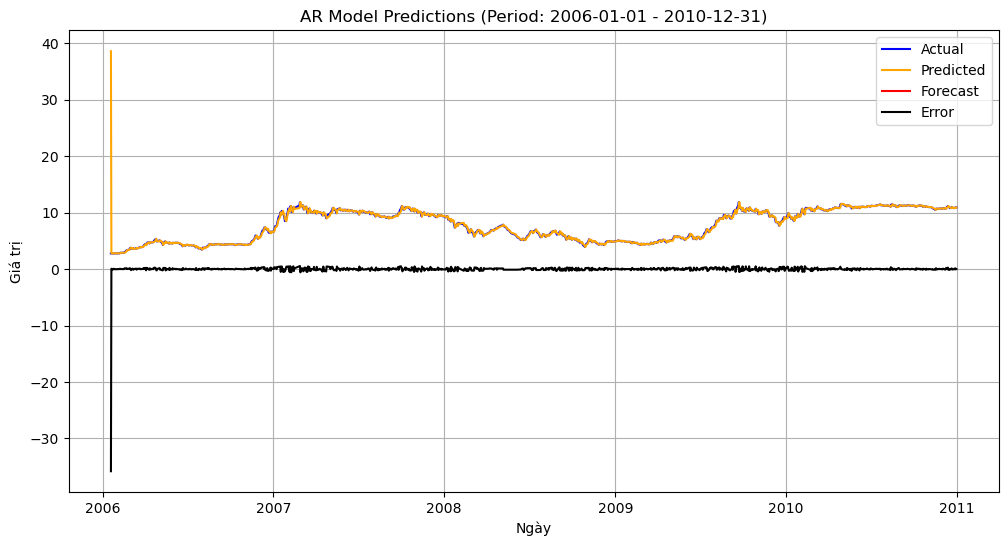

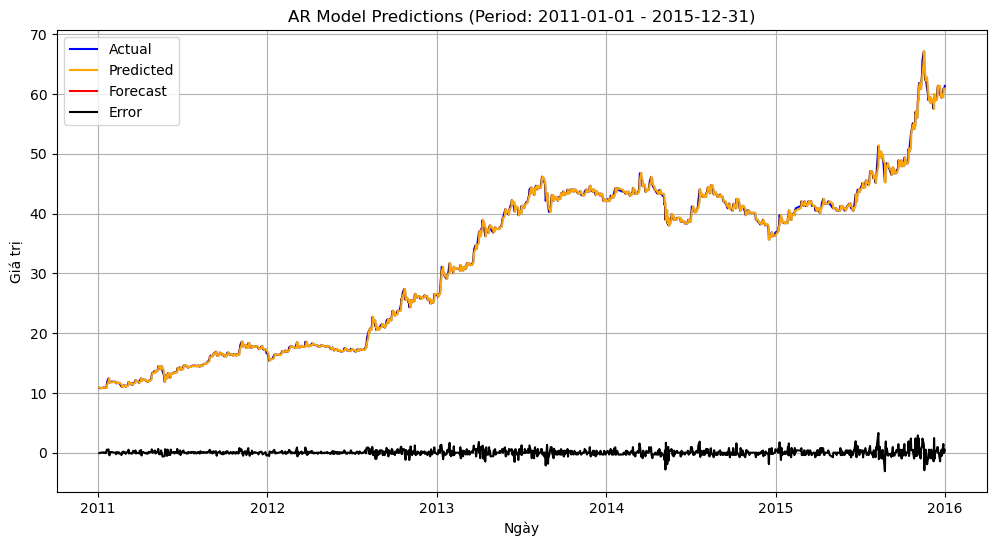

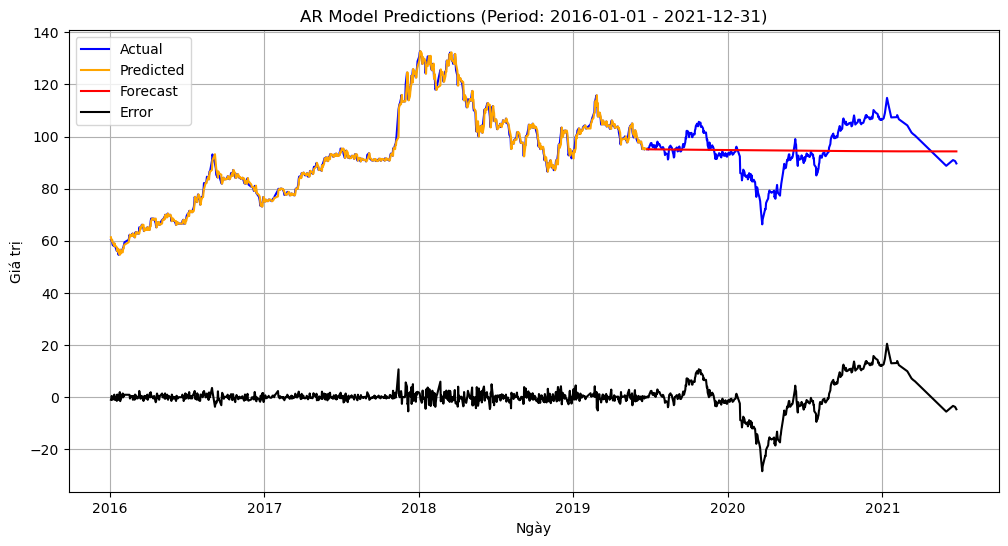

In [34]:
periods = [
  ("2006-01-01", "2010-12-31"),
  ("2011-01-01", "2015-12-31"),
  ("2016-01-01", "2021-12-31"),
] # Đặt các mốc thời gian ứng với từng biểu đồ

for start_date, end_date in periods: # Tạo vòng lặp in ra biểu đồ ứng với từng khoảng thời gian
 ts_subset = ts.loc[start_date:end_date] # Tạo tập subset lưu các phần của ts ứng với từng khoảng thời gian

 plt.figure(figsize=(12, 6)) # Chọn kích thước 12x6

 # Plot cột 'Close' với tên Legend là 'Actual' bằng màu xanh 
 plt.plot(ts_subset.index, ts_subset["Close"], label="Actual", color="blue")

 # Plot cột 'ar_predicted' với tên Legend là 'Predicted' bằng màu cam   
 plt.plot(ts_subset.index, ts_subset['ar_predicted'], label="Predicted", color="orange")
 
 # Plot cột 'ar_forecast' với tên Legend là 'Forecast' bằng màu đỏ   
 plt.plot(ts_subset.index, ts_subset['ar_forecast'], label="Forecast",color='red')

 # Plot cột 'ar_error' với tên Legend là 'Error' bằng màu đen   
 plt.plot(ts_subset.index, ts_subset['ar_error'], label="Error", color='black')

 plt.xlabel("Ngày") # Đặt label trục x là "Ngày"
 plt.ylabel("Giá trị") # Đặt label trục y là "Giá trị"
 plt.title(f"AR Model Predictions (Period: {start_date} - {end_date})") #Đặt tên biểu đồ
 plt.legend() # Setting cho biểu đồ hiện legend
 plt.grid(True) # Setting chỏ biểu đồ hiện mạng lưới

 plt.show() 

#### Plot kết quả mô hình MA trong các khoảng thời gian 5 năm

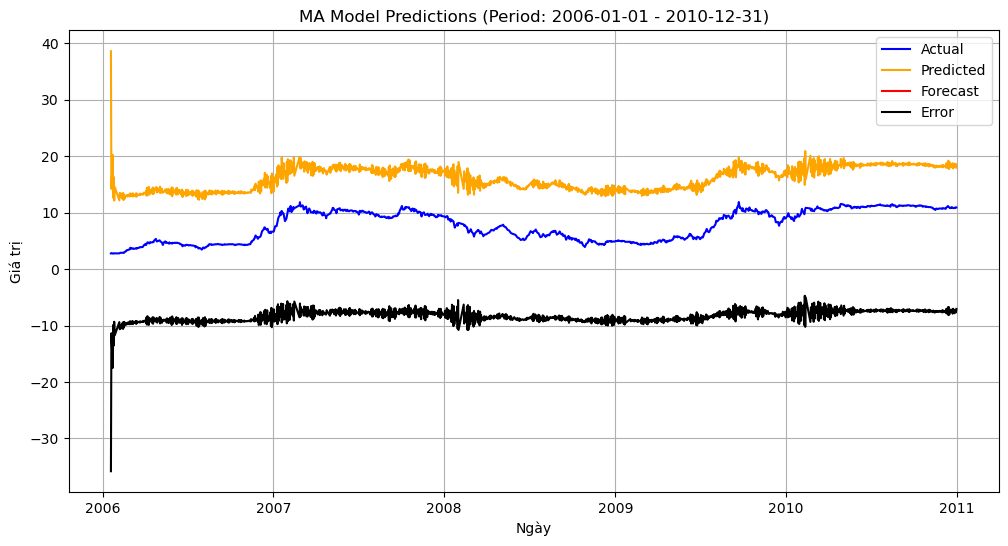

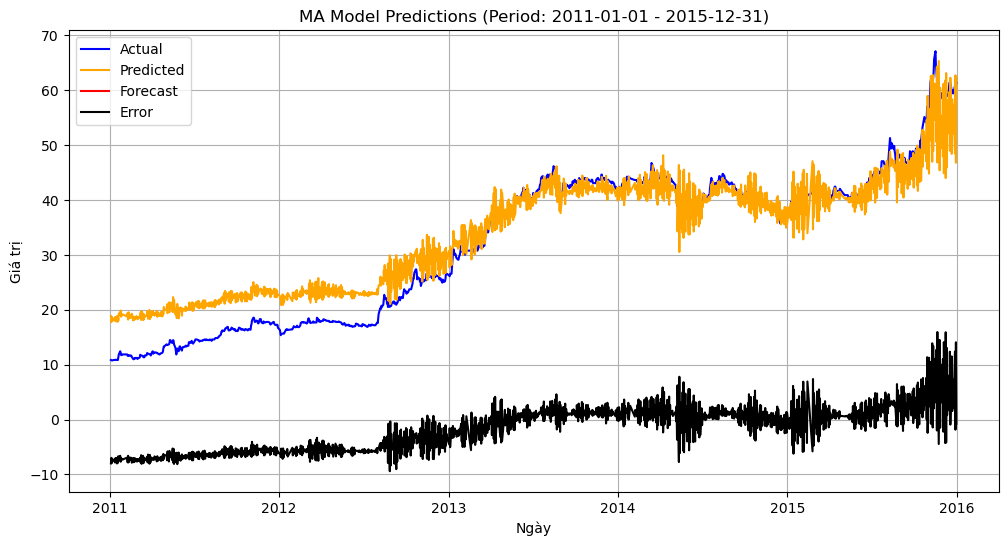

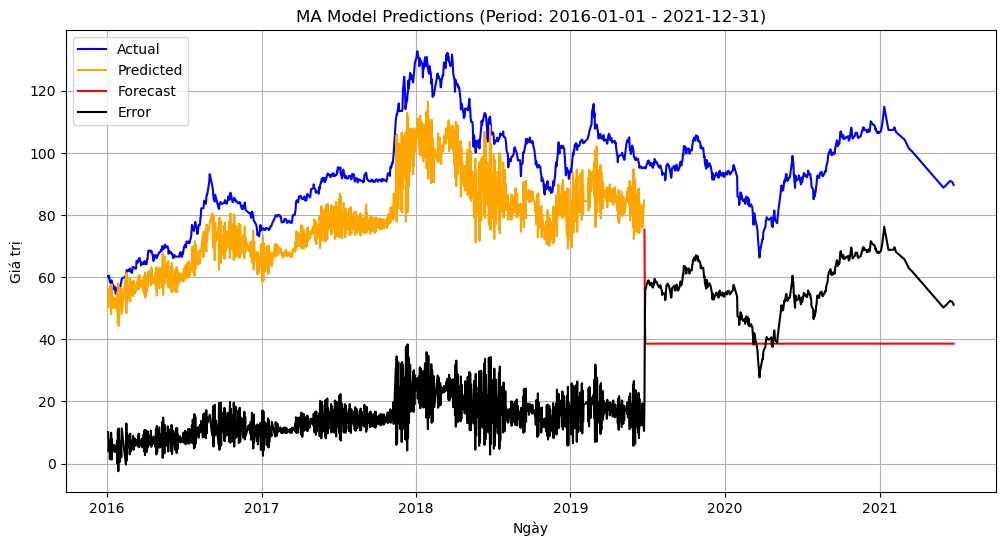

In [35]:
periods = [
  ("2006-01-01", "2010-12-31"),
  ("2011-01-01", "2015-12-31"),
  ("2016-01-01", "2021-12-31"),
] # Đặt các mốc thời gian ứng với từng biểu đồ

for start_date, end_date in periods: # Tạo vòng lặp in ra biểu đồ ứng với từng khoảng thời gian
 ts_subset = ts.loc[start_date:end_date] # Tạo tập subset lưu các phần của ts ứng với từng khoảng thời gian

 plt.figure(figsize=(12, 6)) # Chọn kích thước 12x6
    
 # Plot cột 'Close' với tên Legend là 'Actual' bằng màu xanh 
 plt.plot(ts_subset.index, ts_subset["Close"], label="Actual", color="blue")

 # Plot cột 'ma_predicted' với tên Legend là 'Predicted' bằng màu cam 
 plt.plot(ts_subset.index, ts_subset['ma_predicted'], label="Predicted", color="orange")
    
 # Plot cột 'ma_forecast' với tên Legend là 'Forecast' bằng màu đỏ    
 plt.plot(ts_subset.index, ts_subset['ma_forecast'], label="Forecast",color='red')

 # Plot cột 'ma_error' với tên Legend là 'Error' bằng màu đen 
 plt.plot(ts_subset.index, ts_subset['ma_error'], label="Error", color='black')

 plt.xlabel("Ngày") # Đặt label trục x là "Ngày"
 plt.ylabel("Giá trị") # Đặt label trục y là "Giá trị"
 plt.title(f"MA Model Predictions (Period: {start_date} - {end_date})") #Đặt tên biểu đồ
 plt.legend() # Setting cho biểu đồ hiện legend
 plt.grid(True) # Setting chỏ biểu đồ hiện mạng lưới

 plt.show()

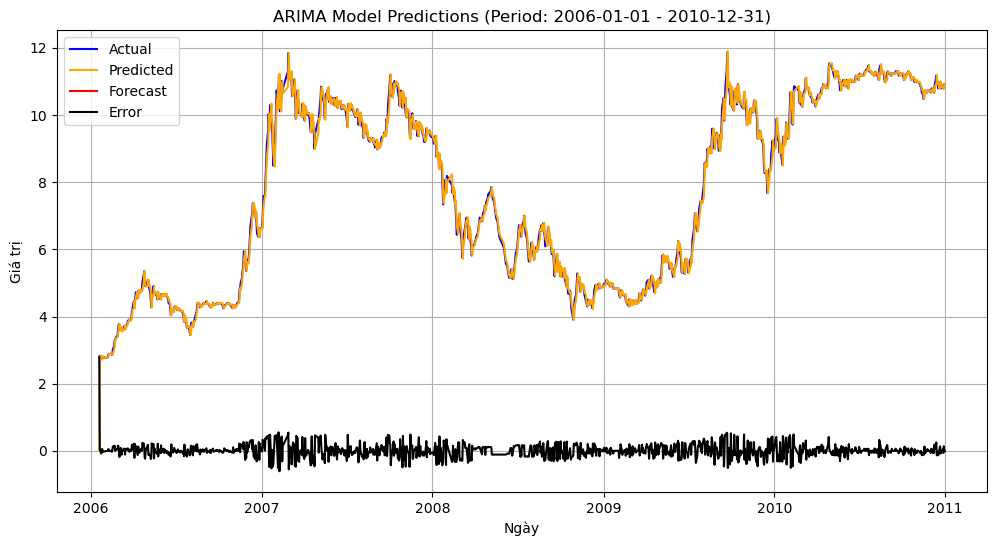

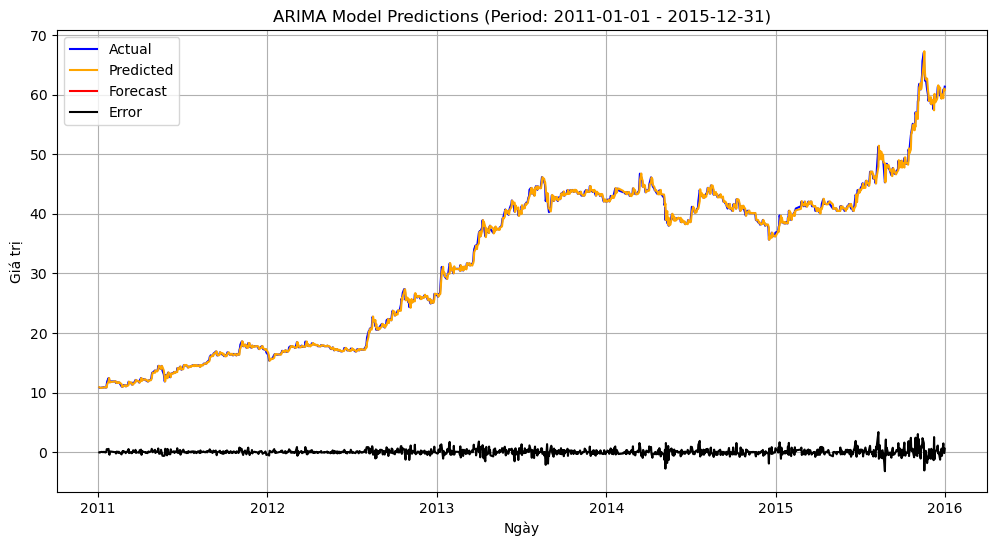

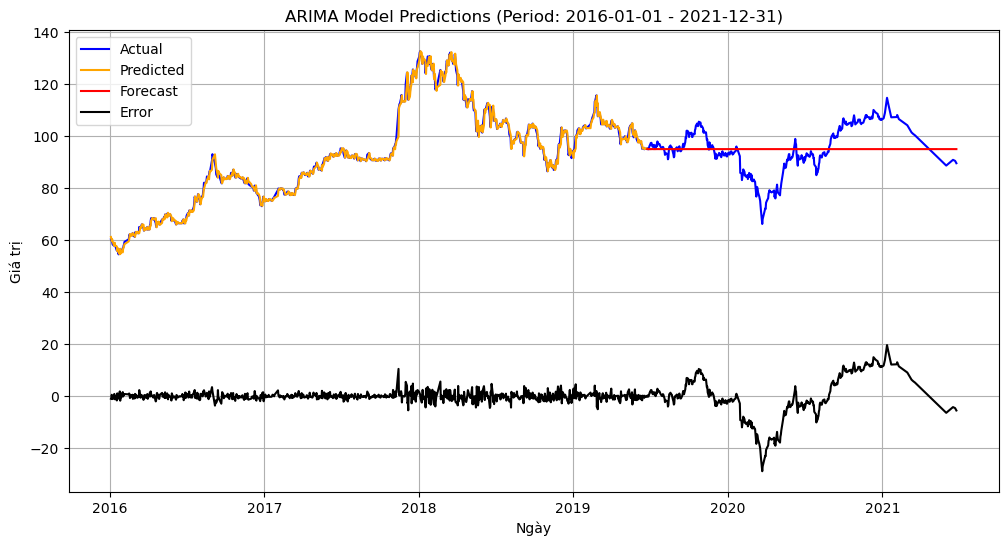

In [36]:
periods = [
  ("2006-01-01", "2010-12-31"),
  ("2011-01-01", "2015-12-31"),
  ("2016-01-01", "2021-12-31"),
] # Đặt các mốc thời gian ứng với từng biểu đồ

for start_date, end_date in periods: # Tạo vòng lặp in ra biểu đồ ứng với từng khoảng thời gian
 ts_subset = ts.loc[start_date:end_date] # Tạo tập subset lưu các phần của ts ứng với từng khoảng thời gian

 plt.figure(figsize=(12, 6)) # Chọn kích thước 12x6

 # Plot cột 'Close' với tên Legend là 'Actual' bằng màu xanh     
 plt.plot(ts_subset.index, ts_subset["Close"], label="Actual", color="blue")

 # Plot cột 'arima_predicted' với tên Legend là 'Predicted' bằng màu cam 
 plt.plot(ts_subset.index, ts_subset['arima_predicted'], label="Predicted", color="orange")
    
 # Plot cột 'arima_forecast' với tên Legend là 'Forecast' bằng màu đỏ     
 plt.plot(ts_subset.index, ts_subset['arima_forecast'], label="Forecast",color='red')

 # Plot cột 'arima_error' với tên Legend là 'Error' bằng màu đem 
 plt.plot(ts_subset.index, ts_subset['arima_error'], label="Error", color='black')

 plt.xlabel("Ngày") # Đặt label trục x là "Ngày"
 plt.ylabel("Giá trị") # Đặt label trục y là "Giá trị"
 plt.title(f"ARIMA Model Predictions (Period: {start_date} - {end_date})") #Đặt tên biểu đồ
 plt.legend() # Setting cho biểu đồ hiện legend
 plt.grid(True) # Setting chỏ biểu đồ hiện mạng lưới

 plt.show()

# 7. Đánh giá và so sánh các mô hình

In [37]:
#Tạo bảng gồm các cột ứng với model và các chỉ số MSE, MAE, MAPE, AIC
print("| {:<10} | {:>10} | {:>10} | {:>10} | {:>10} |".format("Model", "MSE", "MAE", "MAPE", "AIC")) 

# Tính MSE,MAE,MAPE,AIC của từng model
ar_mse = mean_squared_error(test, ar_forecast)
ar_mae = mean_absolute_error(test, ar_forecast)
ar_mape = mean_absolute_percentage_error(test, ar_forecast)

ma_mse = mean_squared_error(test, ma_forecast)
ma_mae = mean_absolute_error(test, ma_forecast)
ma_mape = mean_absolute_percentage_error(test, ma_forecast)

arima_mse = mean_squared_error(test, arima_forecast)
arima_mae = mean_absolute_error(test, arima_forecast)
arima_mape = mean_absolute_percentage_error(test, arima_forecast)

# In các chỉ số dựa trên bẳng đã tạo
print("| {:<10} | {:>10.4f} | {:>10.4f} | {:>10.4f} | {:>10.4f} |".format("AR", ar_mse, ar_mae, ar_mape, ar_model_fit.aic))
print("| {:<10} | {:>10.4f} | {:>10.4f} | {:>10.4f} | {:>10.4f} |".format("MA", ma_mse, ma_mae, ma_mape, ma_model_fit.aic))
print("| {:<10} | {:>10.4f} | {:>10.4f} | {:>10.4f} | {:>10.4f} |".format("ARIMA", arima_mse, arima_mae, arima_mape, arima_model_fit.aic))

| Model      |        MSE |        MAE |       MAPE |        AIC |
| AR         |    74.0997 |     6.4998 |     0.0711 |  7876.6907 |
| MA         |  3210.4990 |    55.9792 |     0.5876 | 24698.1531 |
| ARIMA      |    73.3494 |     6.5140 |     0.0716 |  7842.4808 |


---> Nhìn chung các chỉ số MSE, MAE, MAPE và AIC của mô hình MA là lớn hơn cả, do mô hình MA yêu cầu tính dừng của chuỗi thời gian nghiêm ngặt, khiến cho khi áp dụng với chuỗi thời gian cổ phiếu biến động thì đạt hiệu quả kém nhất trong 3 mô hình. Ngoài ra, dù các chỉ số MSE, MAE, MAPE và AIC tương đối xấp xỉ nhau, nhưng mô hình ARIMA vẫn có các chỉ số đánh giá thấp hơn so với mô hình AR và thấp nhất trong cả 3 mô hình. Điều này chứng tỏ đối với bộ dữ liệu, sử dụng mô hình ARIMA hiệu quả hơn so với MA và AR

---> Đối với mô hình ARIMA, chỉ số MAE=6,4998 chứng tỏ kết quả dự đoán sai lệch trung bình 6,4998 so với giá trị thật, cũng như chỉ số MAPE=0,0716=7,16% chứng tỏ kết quả sai lệch khoảng 7,16%. Kết quả trên là chấp nhận được đối với chuỗi thời gian biến động và khó dự đoán như giá đóng cửa cổ phiếu, tuy nhiên cũng cho thấy mô hình ARIMA còn có nhiều thiếu sót như chưa cân nhắc đến tính mùa vụ.
